Parameters to set:

up, down, left, right

thresh_corr_diff


# Images

In [4]:
import heapq
import os
import sys
import numpy as np
import pandas as pd
# import tifffile as tif
# import h5py
from skimage import io, img_as_float32
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage
from scipy import stats
from skimage.filters import threshold_yen
from skimage.segmentation import find_boundaries
# import IPython.display
# import PIL
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append("../bardensr")
import bardensr
import bardensr.plotting
from DeCRISP import DeCRISP as dcp

In [5]:
n_channels = 2
n_cycles = 5

In [6]:
with open('./data/registered20210714_sg2NEB.npy', 'rb') as f:
    X = np.load(f)

In [7]:
X.shape

(10, 1, 2048, 1280)

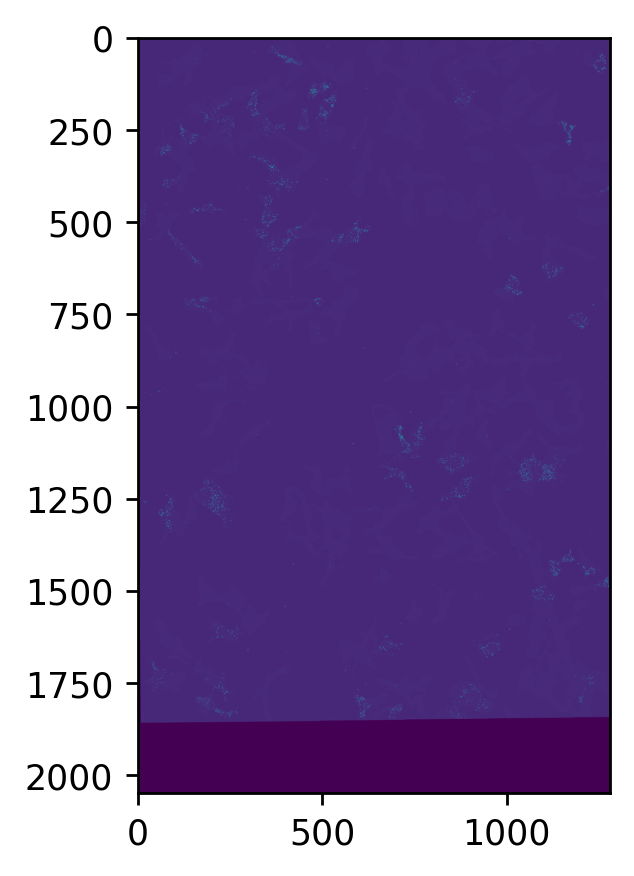

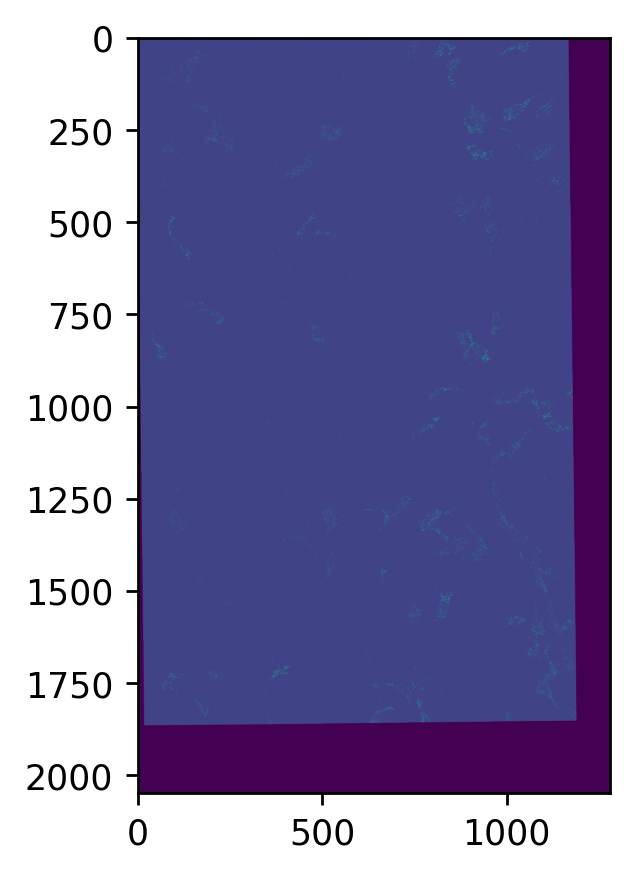

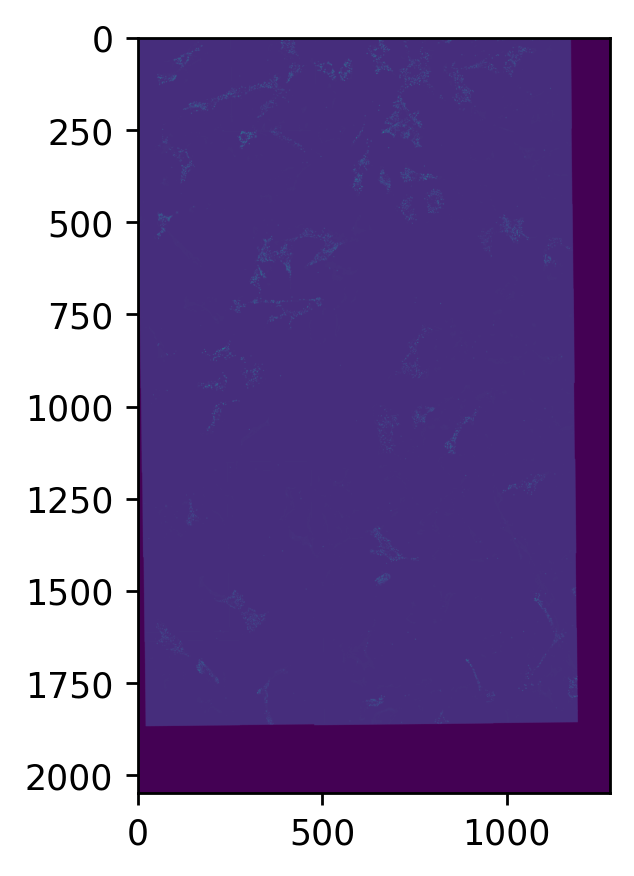

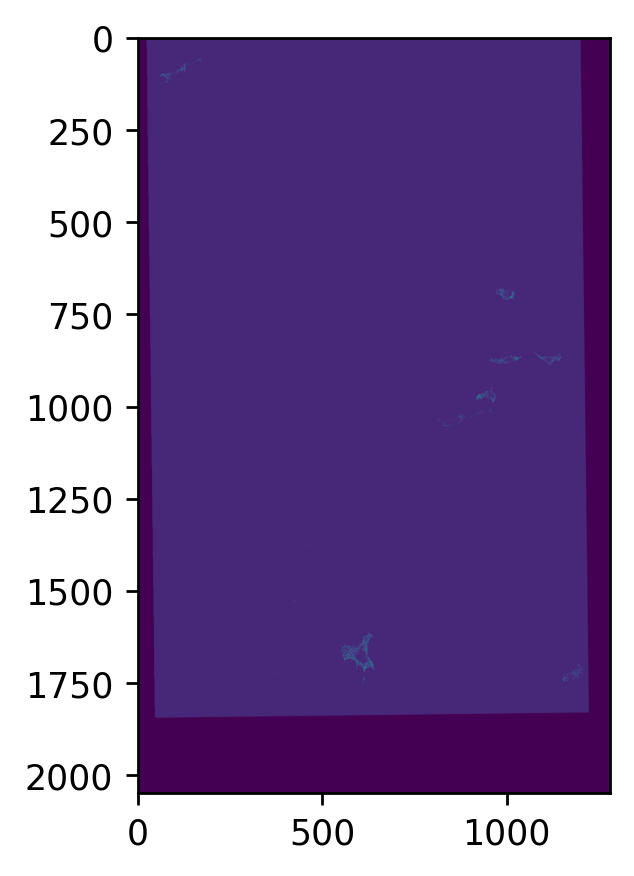

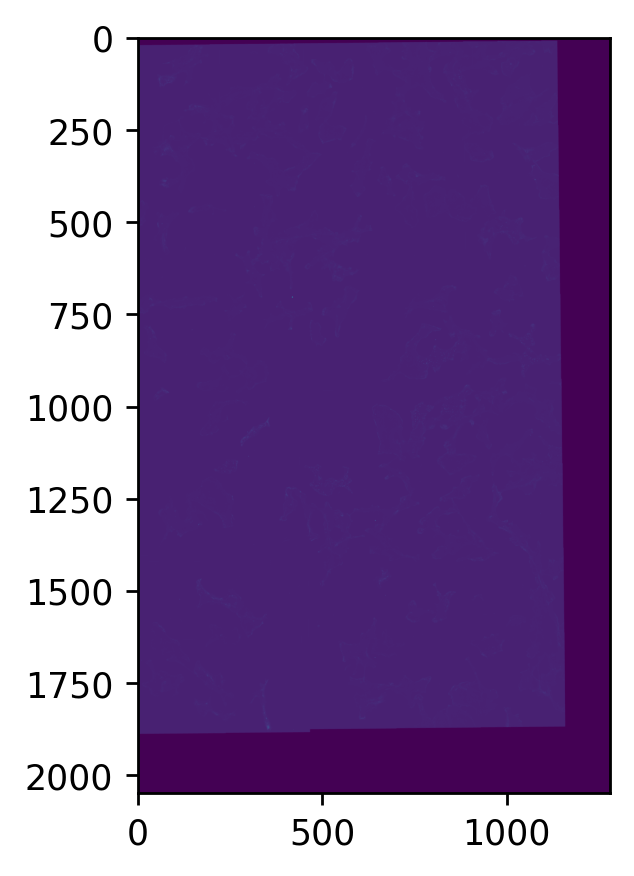

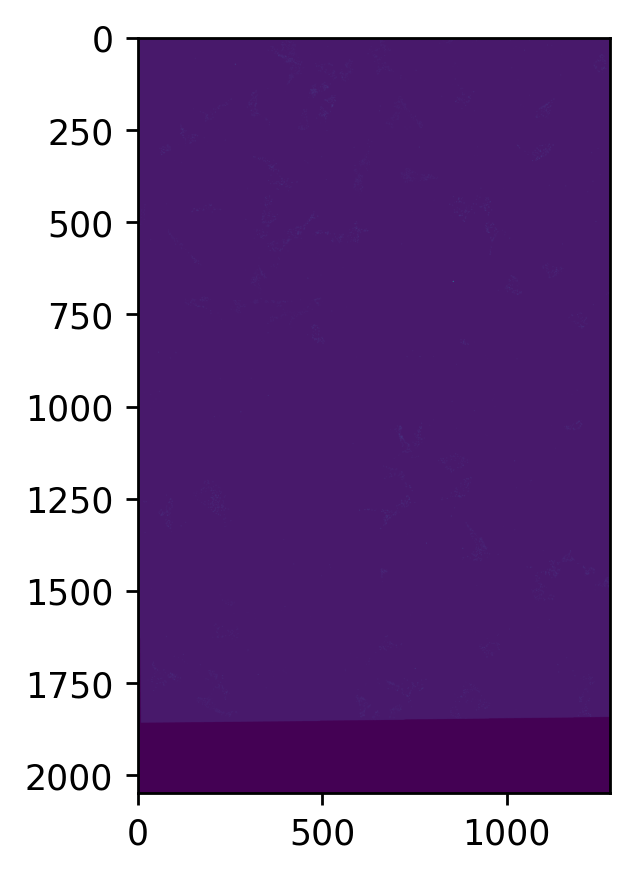

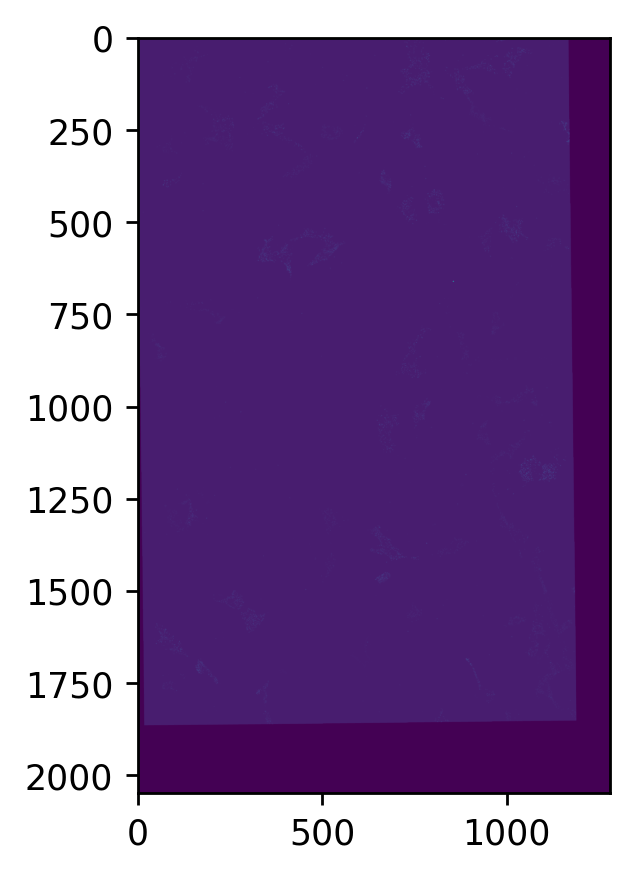

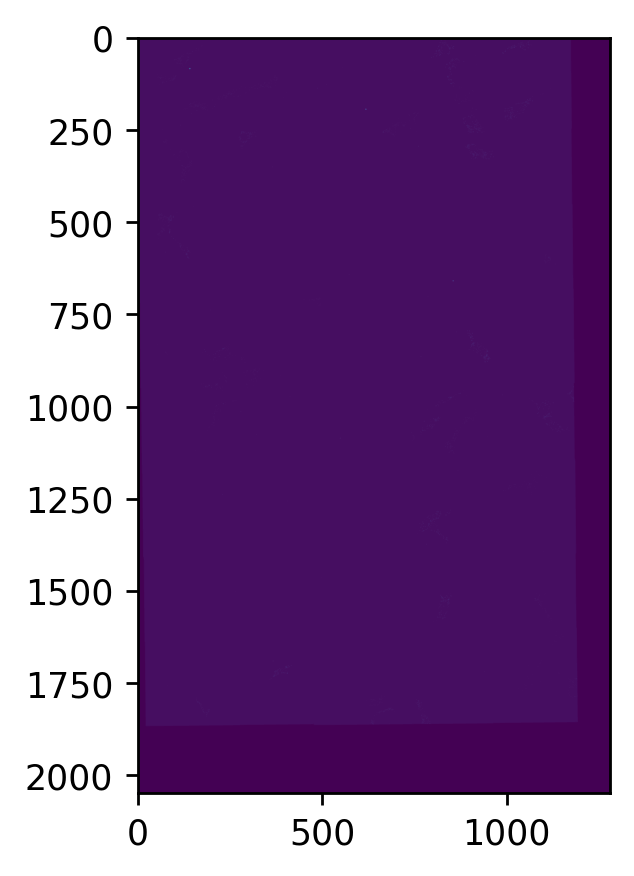

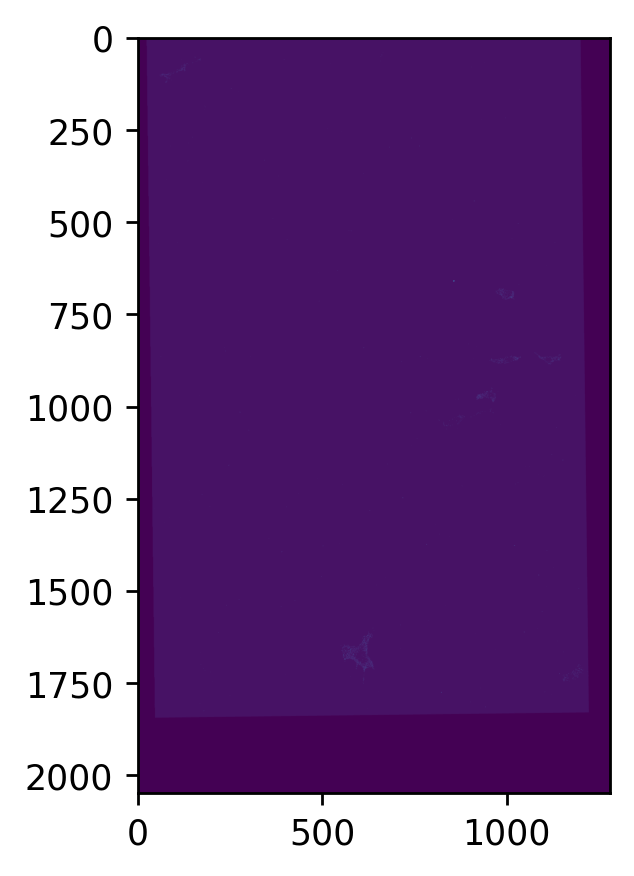

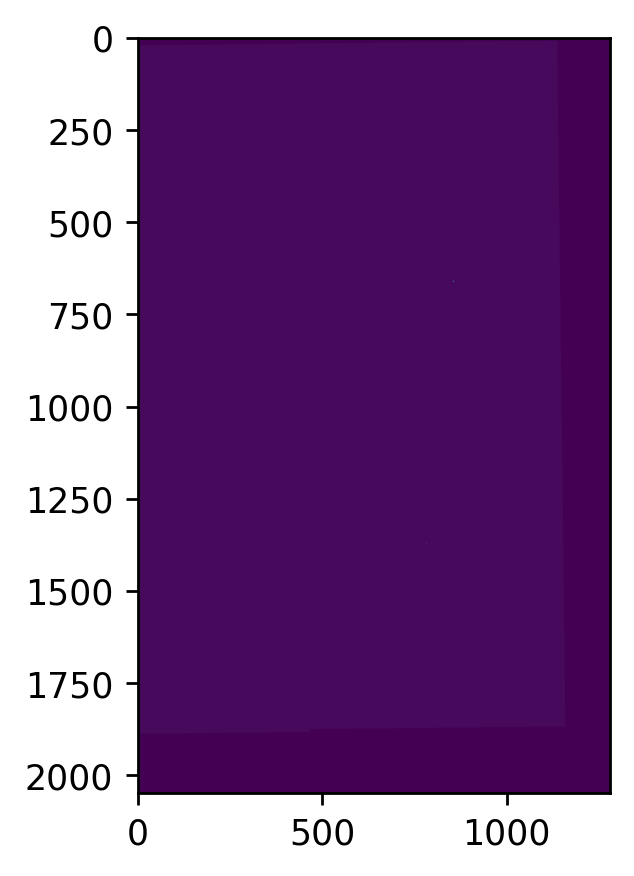

In [8]:
for i in range(X.shape[0]):
    plt.figure(dpi=250)
    plt.imshow(X[i, 0,])

## Remove artifact

In [11]:
up = 0
down = 1800
left = 10
right = 1150

Xcenter = dcp.remove_border(X, up=up, down=down, left=left, right=right)

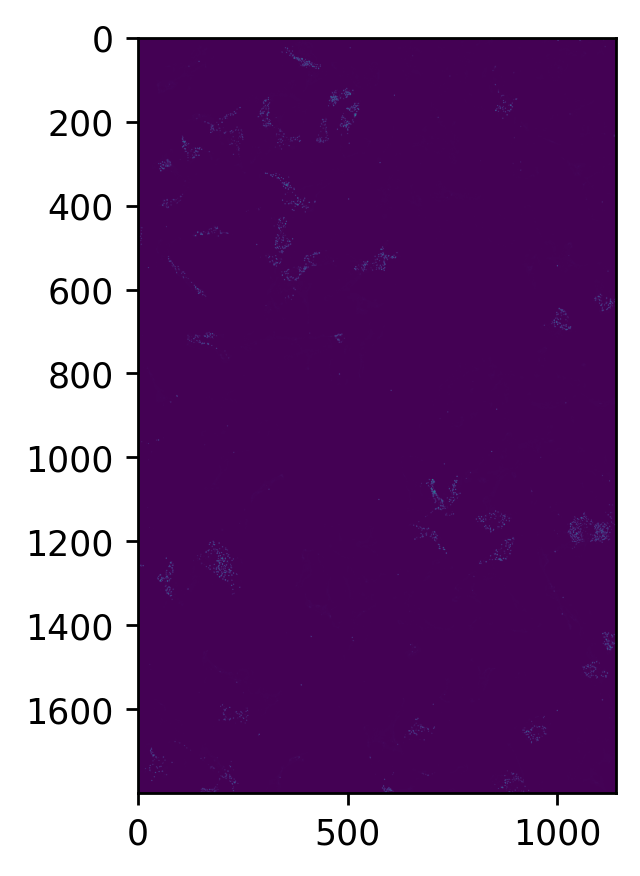

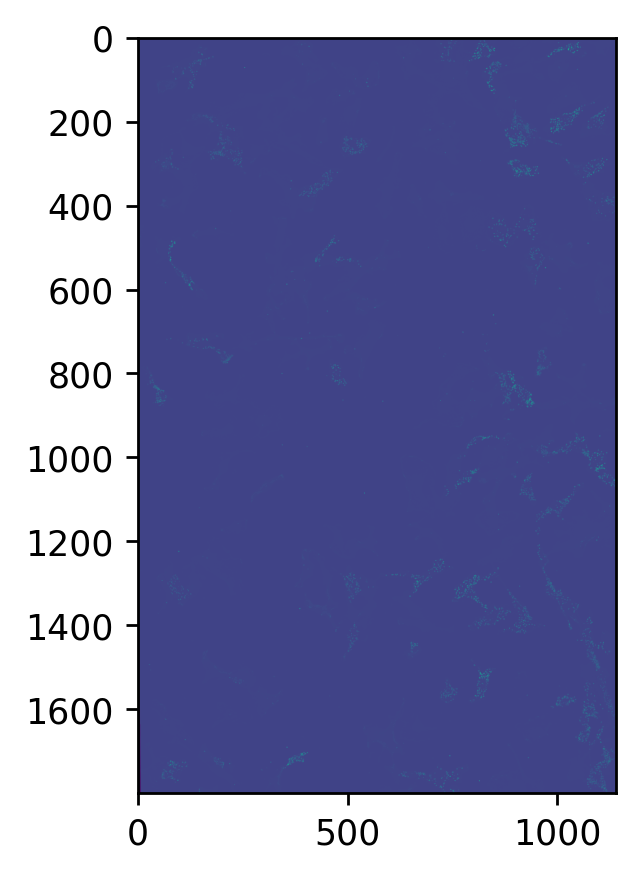

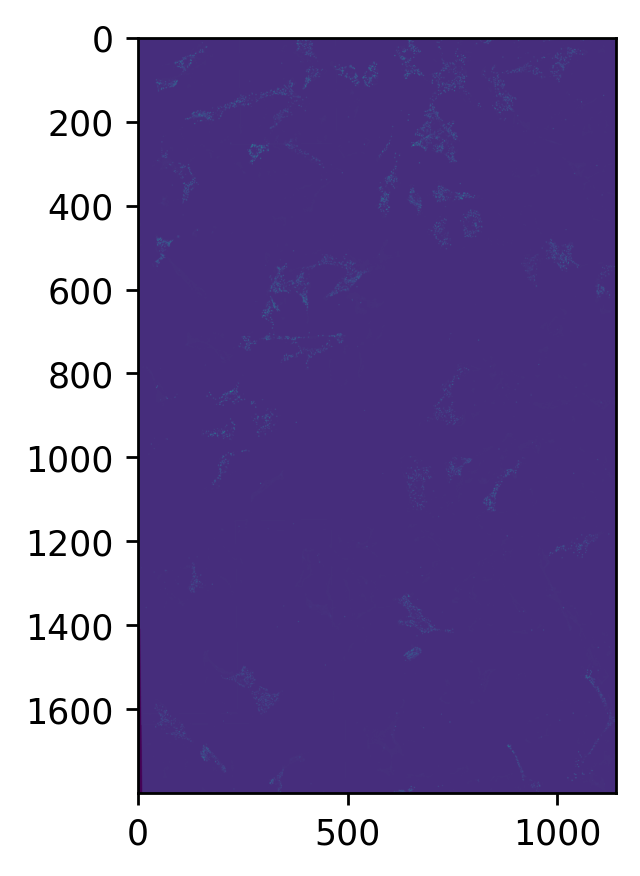

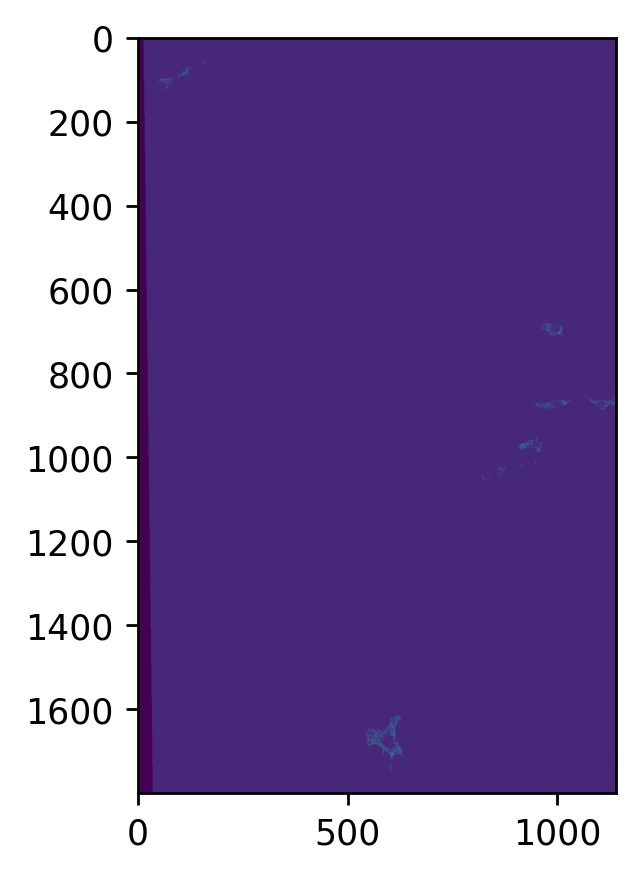

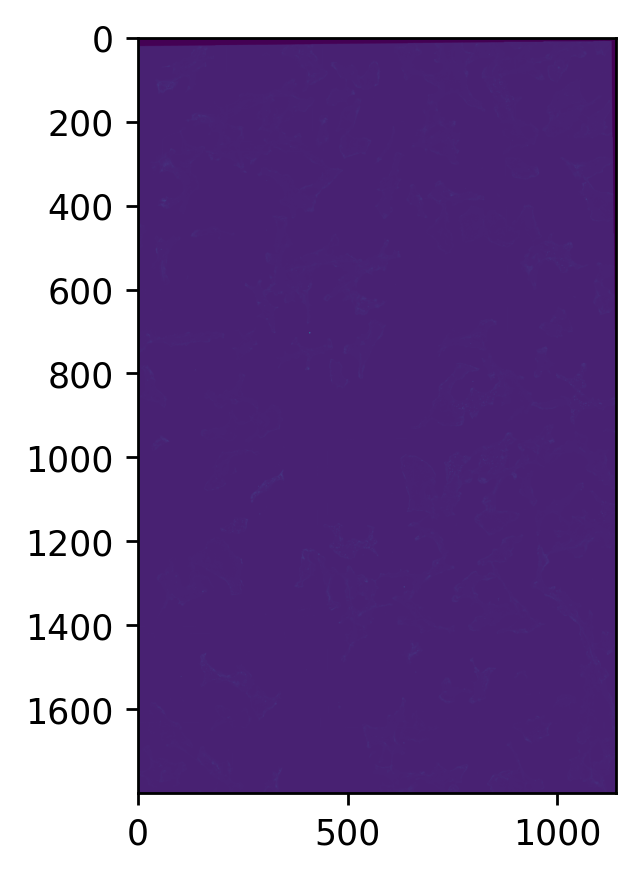

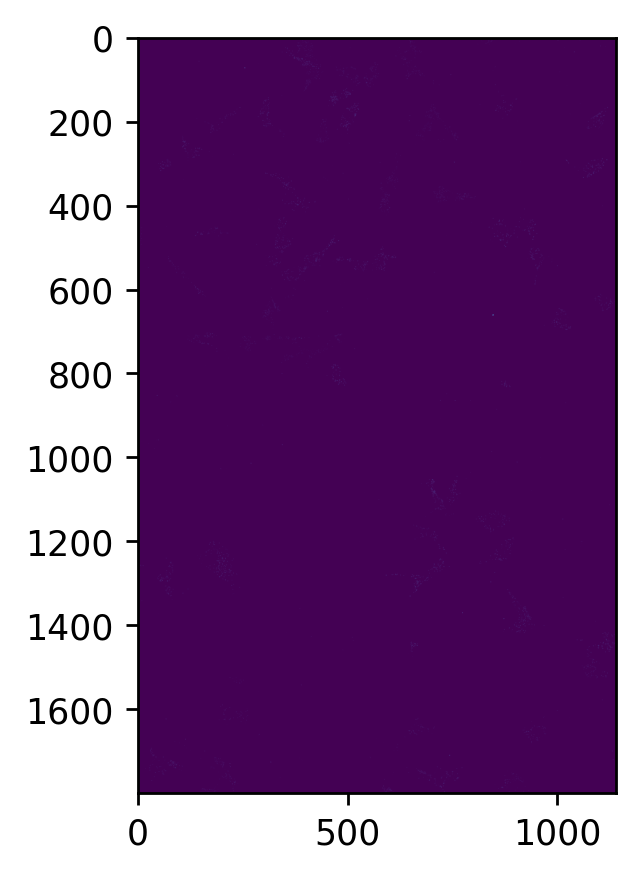

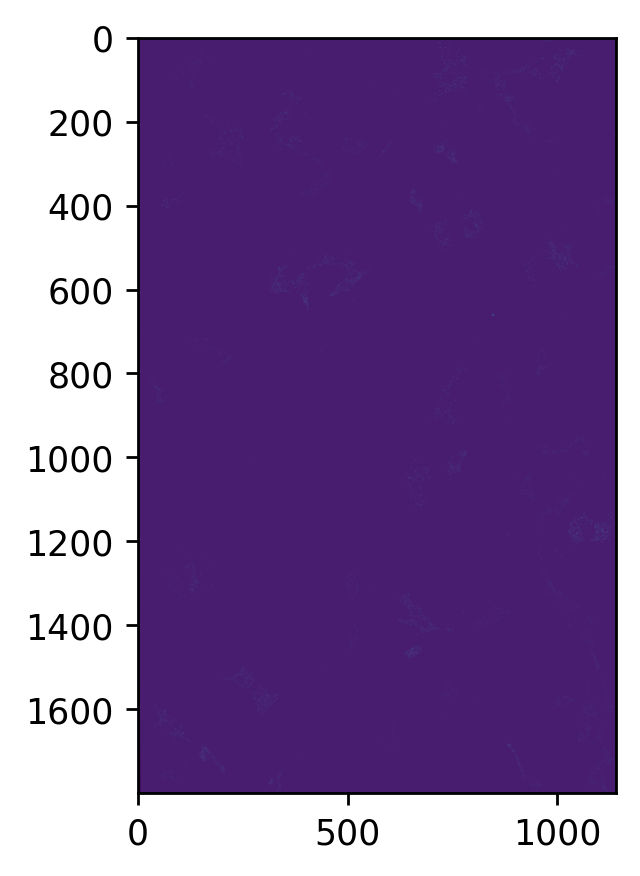

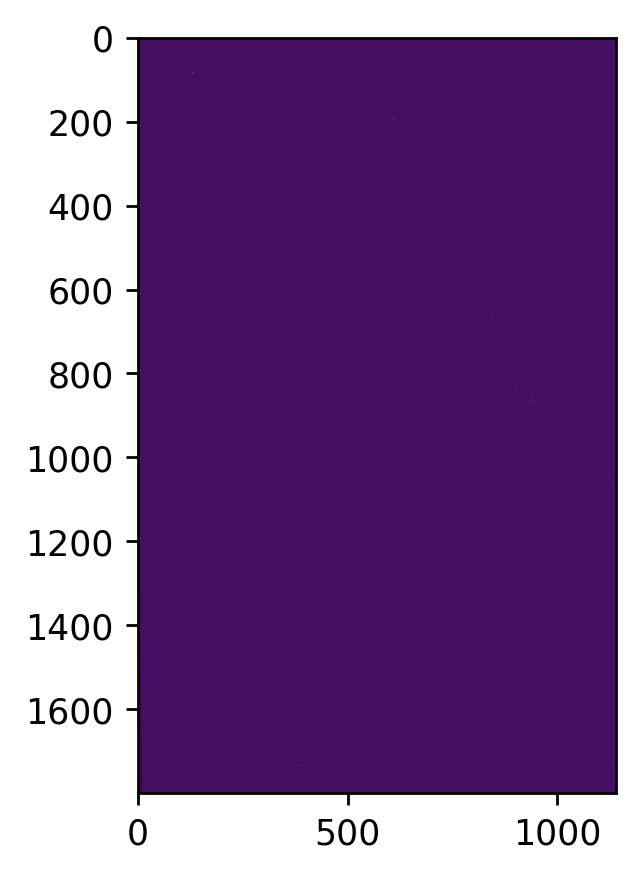

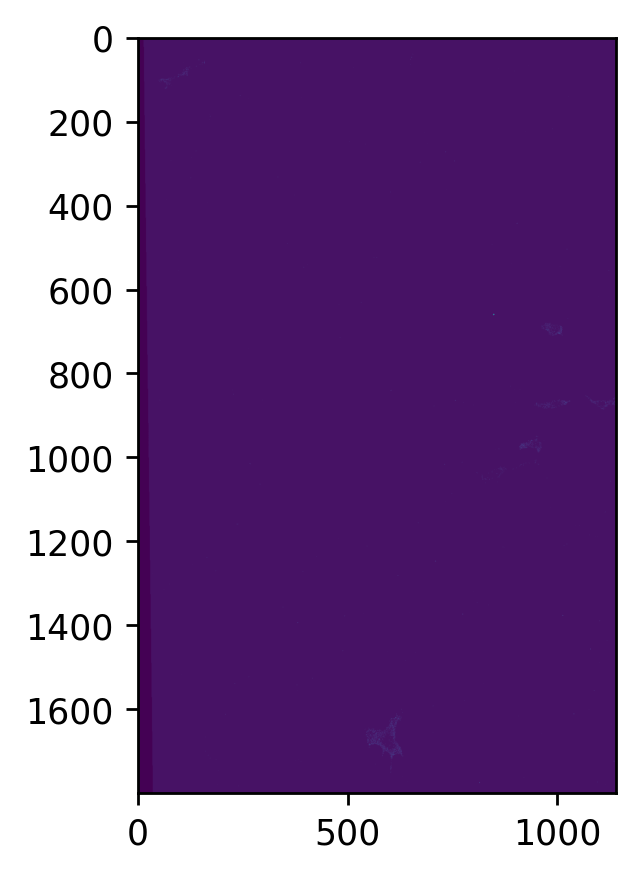

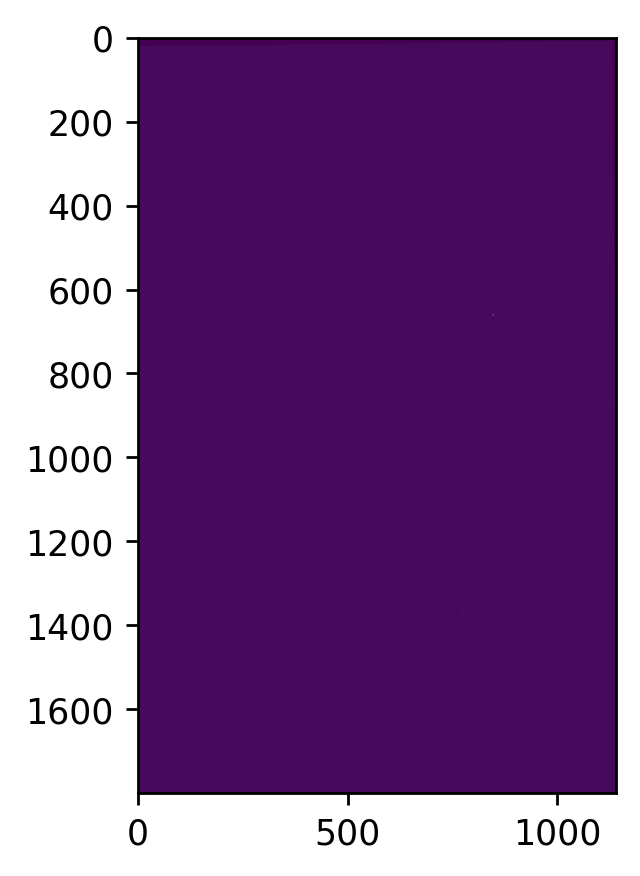

In [10]:
for i in range(Xcenter.shape[0]):
    plt.figure(dpi=250)
    plt.imshow(Xcenter[i, 0,])

# Codebook

The most important is to make sure the codebook and the images are of the same order

In [12]:
codebook = pd.read_csv('./data/CRISPRmap_pilot_codebook_default.csv', dtype=np.int, header=None)
codebook = np.array(codebook)
codebook

array([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0]])

In [13]:
codebook.shape

(10, 10)

# Image processing

## Background subtraction and normalization

In [15]:
Xcenter.shape

(10, 1, 1800, 1140)

In [16]:
# Different from how bardensr did it (use these functions for now because they are tested)
Xnorm = bardensr.preprocessing.background_subtraction(Xcenter, [0,10,10])
Xnorm = bardensr.preprocessing.minmax(Xnorm)

In [17]:
Xnorm.shape

(10, 1, 1800, 1140)

## Thresholding

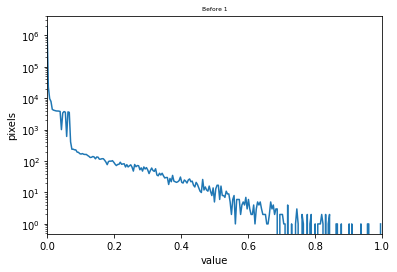

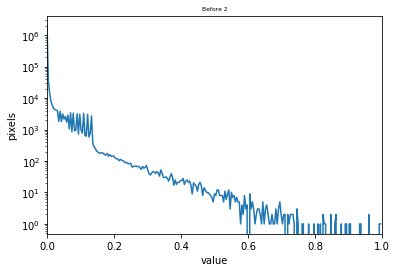

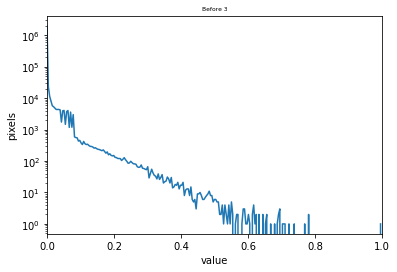

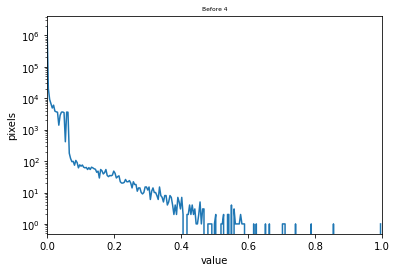

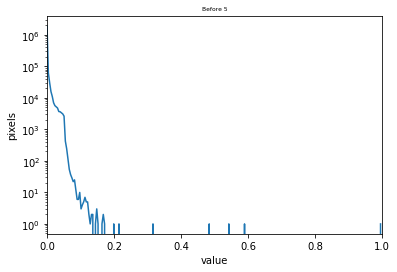

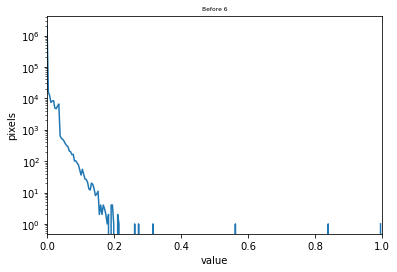

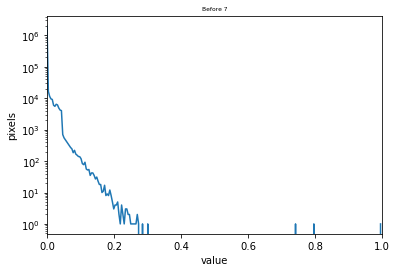

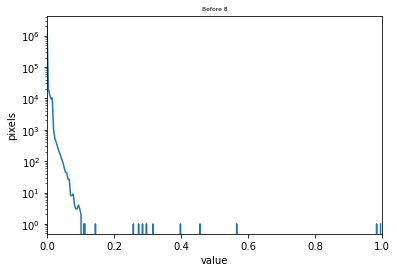

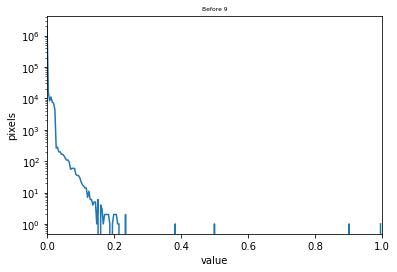

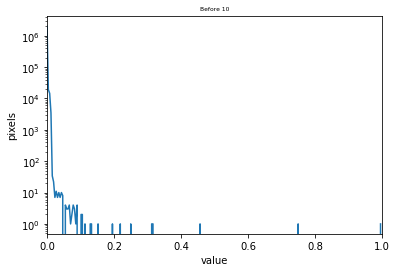

In [17]:
# Distributions before thresholding
for i in range(Xnorm.shape[0]):
    histogram, bin_edges = np.histogram(Xnorm[i, 0, ], bins=256, range=(0, 1))
    plt.figure()
    plt.title(f"Before {i+1}", fontsize=6)
    plt.xlabel("value")
    plt.ylabel("pixels")
    plt.semilogy(bin_edges[0:-1], histogram)
    plt.xlim([0.0, 1.0])
    plt.show()

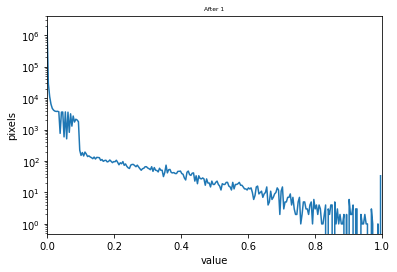

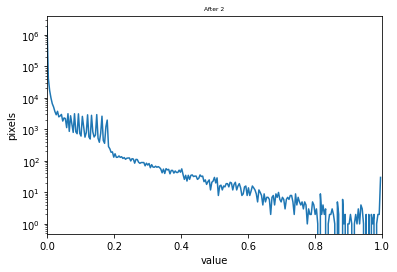

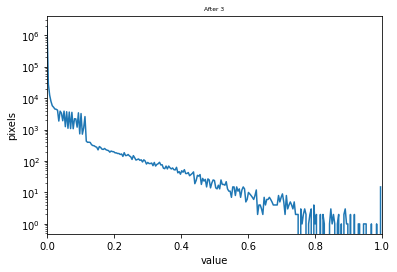

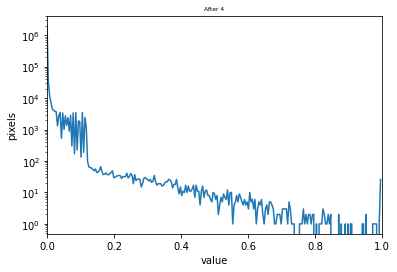

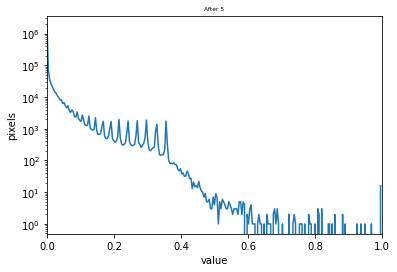

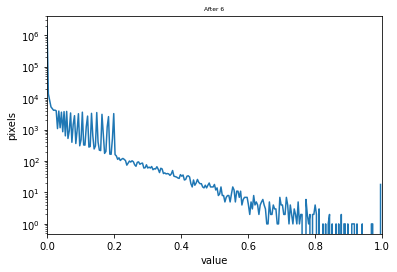

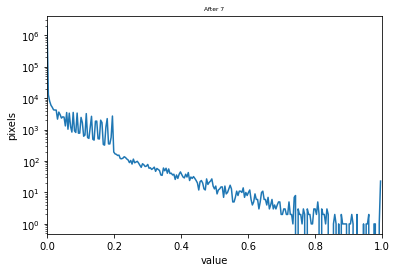

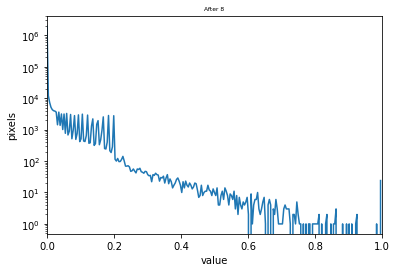

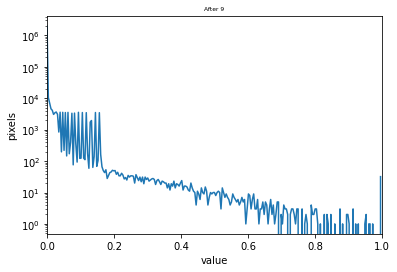

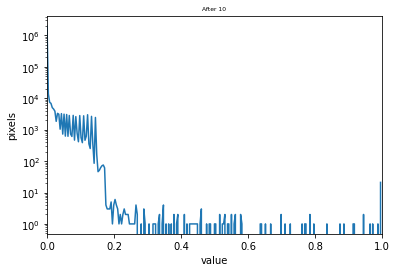

In [23]:
# Don't split this cell
upper = dcp.upper_thresh(Xnorm, n_channels=n_channels, n_cycles=n_cycles, min_bin=3)
Xthresh = dcp.upper_collapse(Xnorm, upper)
Xthresh = bardensr.preprocessing.minmax(Xthresh)
# After
for i in range(Xthresh.shape[0]):
    histogram, bin_edges = np.histogram(Xthresh[i, 0, ], bins=256, range=(0, 1))
    plt.figure()
    plt.title(f"After {i+1}", fontsize=6)
    plt.xlabel("value")
    plt.ylabel("pixels")
    plt.semilogy(bin_edges[0:-1], histogram)
    plt.xlim([0.0, 1.0])
    plt.show()
Xthresh = dcp.lower_thresh(Xthresh)

# Prediction

In [26]:
# Read in the membrane segmentation
with open('./data/20210714masks_mem.npy', 'rb') as m:
    masks_mem = np.load(m)

In [29]:
cell_table = dcp.create_celltable(Xthresh, masks_mem, up_adjust=up, left_adjust=left)
cell_table

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 5., 7., ..., 9., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [51]:
pd.DataFrame(cell_table).to_csv('./result/crisprmap20210714sg2NEB_cell_table.csv')

In [30]:
cell_table.shape

(336, 10)

In [33]:
cell_corr = dcp.cal_metric(cell_table, codebook)
corr_thresh = 0.01
alpha = 0.05  
beta = 0.8  # power
thresh_corr_diff = 0.26
cell_id = pd.DataFrame(dcp.argmax_thresh(cell_corr, axis=1, thresh=corr_thresh), columns=['barcode'])
cell_id['correlation_max'] = dcp.minmax(np.max(cell_corr, axis=1), min_all=np.min(cell_corr), max_all=np.max(cell_corr))
cell_id['correlation_2nd_max'] = dcp.minmax([heapq.nlargest(2, cell_corr[i,])[1] for i in cell_id.index], min_all=np.min(cell_corr), max_all=np.max(cell_corr))
cell_id['correlation_difference'] = cell_id['correlation_max'] - cell_id['correlation_2nd_max']
cell_id['select_by_correlation'] = cell_id['correlation_difference'] > thresh_corr_diff
cell_id['spots_max'] = np.max(cell_table, axis=1)
cell_id['spots_sum'] = np.sum(cell_table, axis=1)
cell_id['spots_needed'] = cell_id['correlation_max'].apply(dcp.sample_size, alpha=alpha, beta=beta)
cell_id['select_by_spots'] = cell_id['spots_sum'] > cell_id['spots_needed']
cell_id['selected'] = cell_id['select_by_correlation'] & cell_id['select_by_spots']
cell_id.head()

,barcode,correlation_max,correlation_2nd_max,correlation_difference,select_by_correlation,spots_max,spots_sum,spots_needed,select_by_spots,selected
0,-1,0.000000,0.000000,0.000000,False,0.0,0.0,31395550336760,False,False
1,4,0.707106,0.707106,0.000000,False,1.0,1.0,13,False,False
2,4,0.812277,0.710742,0.101535,False,9.0,30.0,9,True,False
3,0,0.989949,0.565685,0.424264,True,4.0,7.0,4,True,True
4,6,0.987935,0.564535,0.423401,True,28.0,52.0,4,True,True


In [91]:
cell_id.to_csv('./result/crisprmap20210714sg2NEB_picklemax_cell_id_all.csv', index=False)

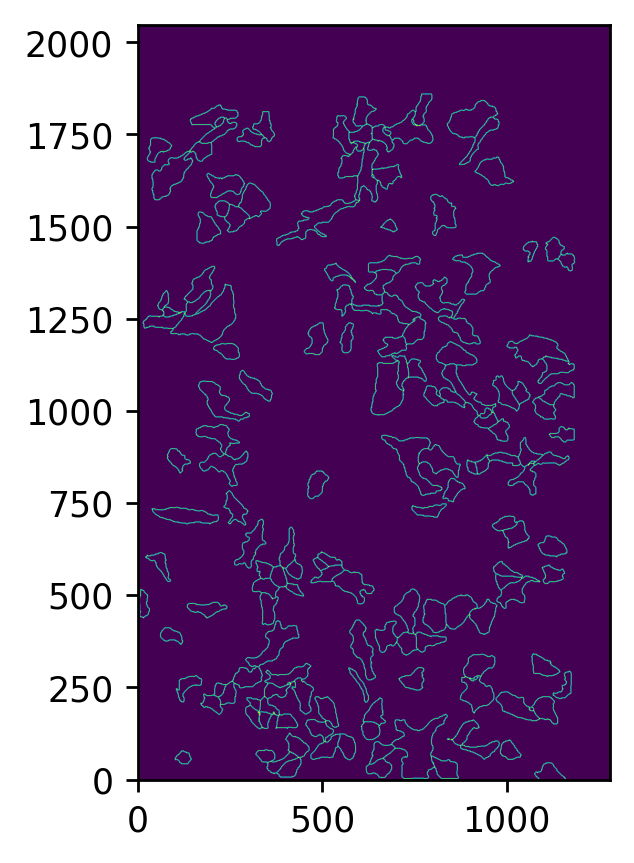

In [34]:
high_quality = cell_id[cell_id['correlation_difference']>0.26]
high_quality_mem = np.zeros(masks_mem.shape)
for i in high_quality.index:
    high_quality_mem[np.array(masks_mem)==i] = i
plt.figure(dpi=250)
plt.imshow(find_boundaries(high_quality_mem), origin='lower')

In [71]:
np.sum(cell_table, axis=1).shape

(336,)

In [80]:
# cell_id.sort_values(by=['correlation_max'], ascending=False).head(20)

In [73]:
# cell_id.sort_values(by=['corr_diff'], ascending=False).head(20)

<AxesSubplot:xlabel='correlation_difference', ylabel='Count'>

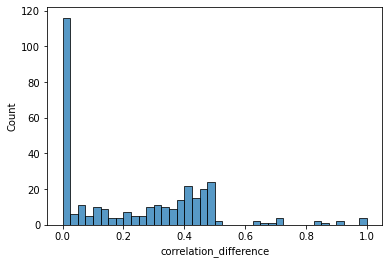

In [74]:
sns.histplot(data=cell_id, x="correlation_difference", binwidth=0.025)

In [75]:
# sns.histplot(data=cell_id, x="max")

In [76]:
# sns.histplot(data=cell_id, x="second_max")

In [ ]:
# sns.histplot(data=cell_id, x="max")

In [ ]:
# set(cell_id['max'])

In [ ]:
np.max(cell_corr)

In [ ]:
cell_corr.shape

In [ ]:
# sh = sns.histplot(data=cell_id, x="spots_sum", binwidth=10)
# sh.set(xlim=(0, 250))

In [ ]:
sh = sns.histplot(data=cell_id, x="spots_max", binwidth=2)
# sh.set(xlim=(0, 250))

In [ ]:
np.median(cell_id.spots_max)

<!-- list1 = [10, 20, 4, 45, 99]
 
# new_list is a set of list1
new_list = set(list1)
 
# removing the largest element from temp list
new_list.remove(max(new_list))
 
# elements in original list are not changed
# print(list1)
 
print(max(new_list)) -->